In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
device = torch.device('cuda') if (torch.cuda.is_available()) else torch.device('cpu')
device

device(type='cuda')

In [2]:
# complete = pd.read_csv('EOF_Bath_SPacific.csv')
complete = pd.read_csv('/kaggle/input/argo-nn-spacific/SPacific.csv')
complete

,Unnamed: 0,folderidx,float,profileidx,year,month,day,lat,lon,nlat,...,prev3_ts5,prev3_ts6,prev3_ts7,prev3_ts8,prev3_dy,prev3_dx,ssh1,ssh2,bath1,bath2
0,112,2.0,2902573.0,125.0,2017.0,3.0,3.0,-27.995,-120.065,-28.145,...,0.309652,0.366698,-0.483323,0.657106,-0.229,-0.273,0.630030,-1.000000,1.0,0.031732
1,113,2.0,2902573.0,126.0,2017.0,3.0,13.0,-28.145,-120.164,-28.267,...,0.400750,0.479525,-0.505345,0.637936,-0.136,-0.286,1.000000,-0.779453,1.0,0.200338
2,114,2.0,2902573.0,127.0,2017.0,3.0,23.0,-28.267,-120.216,-28.250,...,0.342933,0.443193,-0.442858,0.514106,-0.128,-0.221,0.905253,-1.000000,1.0,0.119882
3,115,2.0,2902573.0,128.0,2017.0,4.0,3.0,-28.250,-120.344,-28.163,...,0.259838,0.461459,-0.452919,0.496550,-0.150,-0.099,1.000000,0.031837,1.0,0.073253
4,116,2.0,2902573.0,129.0,2017.0,4.0,13.0,-28.163,-120.430,-27.990,...,0.482292,0.711307,-0.636107,0.681706,-0.122,-0.052,-0.189491,-1.000000,1.0,0.232778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26620,53056,10.0,3902389.0,134.0,2022.0,8.0,30.0,-20.123,-109.789,-20.091,...,1.104784,0.609725,-0.550078,-0.118207,0.045,0.080,-0.551358,1.000000,-1.0,0.129248
26621,53057,10.0,3902389.0,135.0,2022.0,9.0,9.0,-20.091,-109.661,-20.018,...,1.169894,0.763656,-0.693145,0.005258,0.020,0.090,-0.028281,1.000000,-1.0,0.230699
26622,53058,10.0,3902389.0,136.0,2022.0,9.0,19.0,-20.018,-109.584,-19.891,...,1.127813,0.338755,-0.503737,-0.133409,-0.007,0.128,-0.086688,1.000000,-1.0,0.266634
26623,53059,10.0,3902389.0,154.0,2023.0,3.0,17.0,-20.220,-108.673,-20.056,...,1.310212,0.852507,-0.832035,0.113673,-0.303,-0.064,1.000000,-0.146425,-1.0,0.132655


In [3]:
complete.head(50)

,Unnamed: 0,folderidx,float,profileidx,year,month,day,lat,lon,nlat,...,prev3_ts5,prev3_ts6,prev3_ts7,prev3_ts8,prev3_dy,prev3_dx,ssh1,ssh2,bath1,bath2
0,112,2.0,2902573.0,125.0,2017.0,3.0,3.0,-27.995,-120.065,-28.145,...,0.309652,0.366698,-0.483323,0.657106,-0.229,-0.273,0.630030,-1.000000,1.000000,0.031732
1,113,2.0,2902573.0,126.0,2017.0,3.0,13.0,-28.145,-120.164,-28.267,...,0.400750,0.479525,-0.505345,0.637936,-0.136,-0.286,1.000000,-0.779453,1.000000,0.200338
2,114,2.0,2902573.0,127.0,2017.0,3.0,23.0,-28.267,-120.216,-28.250,...,0.342933,0.443193,-0.442858,0.514106,-0.128,-0.221,0.905253,-1.000000,1.000000,0.119882
3,115,2.0,2902573.0,128.0,2017.0,4.0,3.0,-28.250,-120.344,-28.163,...,0.259838,0.461459,-0.452919,0.496550,-0.150,-0.099,1.000000,0.031837,1.000000,0.073253
4,116,2.0,2902573.0,129.0,2017.0,4.0,13.0,-28.163,-120.430,-27.990,...,0.482292,0.711307,-0.636107,0.681706,-0.122,-0.052,-0.189491,-1.000000,1.000000,0.232778
5,117,2.0,2902573.0,130.0,2017.0,4.0,22.0,-27.990,-120.652,-27.808,...,0.534783,0.603244,-0.601384,0.508919,0.017,-0.128,-0.053026,-1.000000,-0.068842,1.000000
6,118,2.0,2902573.0,131.0,2017.0,5.0,2.0,-27.808,-120.970,-27.651,...,0.640600,1.051018,-0.737335,0.710894,0.087,-0.086,-0.471371,-1.000000,0.450265,1.000000
7,119,2.0,2902573.0,132.0,2017.0,5.0,12.0,-27.651,-121.421,-27.609,...,0.540655,0.741024,-0.644372,0.550055,0.173,-0.222,-0.104666,-1.000000,-0.340642,1.000000
8,120,2.0,2902573.0,133.0,2017.0,5.0,22.0,-27.609,-121.743,-27.623,...,0.564260,0.800196,-0.607703,0.579257,0.182,-0.318,-0.082962,-1.000000,1.000000,0.299927
9,121,2.0,2902573.0,134.0,2017.0,6.0,2.0,-27.623,-122.033,-27.590,...,0.495979,0.972258,-0.630542,0.705496,0.157,-0.451,0.088565,-1.000000,0.717516,1.000000


In [26]:
data = complete
# find correlation between prev_dx and dx
prev_dx = data.get('prev_dx')
dx = data.get('dx')
prev_dy = data.get('prev_dy')
dy = data.get('dy')
dx.corr(prev_dx), dy.corr(prev_dy)

(0.7336147598805854, 0.6875866802216465)

In [27]:
# chosen_params = ['bath1', 'bath2', 'prev_dy', 'prev_dx', 'dy', 'dx']
chosen_params = ['ts1', 'ts2', 'ts3', 'ts4', 'ts5', 'ts6', 'ts7', 'ts8',
  'prev_ts1', 'prev_ts2', 'prev_ts3', 'prev_ts4', 'prev_ts5', 'prev_ts6',
  'prev_ts7', 'prev_ts8','prev2_ts1', 'prev2_ts2', 'prev2_ts3', 'prev2_ts4', 'prev2_ts5', 'prev2_ts6',
  'prev2_ts7', 'prev2_ts8','prev3_ts1', 'prev3_ts2', 'prev3_ts3', 'prev3_ts4', 'prev3_ts5', 'prev3_ts6',
  'prev3_ts7', 'prev3_ts8', 'bath1', 'bath2', 'ssh1', 'ssh2', 'prev_dy', 'prev_dx', 'prev2_dy', 'prev2_dx',
                 'prev3_dy', 'prev3_dx', 'dy', 'dx']
# chosen_params = ['ts1', 'ts2', 'ts3', 'ts4', 'ts5', 'ts6', 'ts7', 'ts8', 'prev_dy', 'prev_dx', 'dy', 'dx']
# chosen_params = ['prev_dy', 'prev_dx', 'dy', 'dx']
# chosen_params = ['ts1', 'ts2', 'ts3', 'ts4', 'ts5', 'ts6', 'ts7', 'ts8', 'bath1', 'bath2', 'prev_dy', 'prev_dx', 'dy', 'dx']

final = data[chosen_params].dropna()
final

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,prev_ts1,prev_ts2,...,ssh1,ssh2,prev_dy,prev_dx,prev2_dy,prev2_dx,prev3_dy,prev3_dx,dy,dx
0,1.192006,-5.597361,-0.062255,0.513387,0.259838,0.461459,-0.452919,0.496550,0.988142,-5.643554,...,0.630030,-1.000000,-0.128,-0.221,-0.136,-0.286,-0.229,-0.273,-0.150,-0.099
1,0.486643,-5.805338,-0.495626,1.023332,0.482292,0.711307,-0.636107,0.681706,1.192006,-5.597361,...,1.000000,-0.779453,-0.150,-0.099,-0.128,-0.221,-0.136,-0.286,-0.122,-0.052
2,-0.166054,-6.147102,-0.665207,1.033204,0.534783,0.603244,-0.601384,0.508919,0.486643,-5.805338,...,0.905253,-1.000000,-0.122,-0.052,-0.150,-0.099,-0.128,-0.221,0.017,-0.128
3,-1.246517,-6.414328,-1.303555,1.538312,0.640600,1.051018,-0.737335,0.710894,-0.166054,-6.147102,...,1.000000,0.031837,0.017,-0.128,-0.122,-0.052,-0.150,-0.099,0.087,-0.086
4,-0.670537,-6.280565,-0.912565,1.185883,0.540655,0.741024,-0.644372,0.550055,-1.246517,-6.414328,...,-0.189491,-1.000000,0.087,-0.086,0.017,-0.128,-0.122,-0.052,0.173,-0.222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26620,-0.103917,-4.516683,0.146737,1.949804,1.231033,0.700594,-0.679503,-0.065859,0.116208,-4.428133,...,-0.551358,1.000000,-0.007,0.128,0.020,0.090,0.045,0.080,0.032,0.128
26621,-0.704889,-4.651527,-0.076126,2.052576,1.312617,0.767989,-0.819506,0.113578,-0.103917,-4.516683,...,-0.028281,1.000000,0.032,0.128,-0.007,0.128,0.020,0.090,0.073,0.077
26622,-0.826809,-4.662544,-0.207767,2.174357,1.289403,0.986241,-0.897816,0.204583,-0.704889,-4.651527,...,-0.086688,1.000000,0.073,0.077,0.032,0.128,-0.007,0.128,0.127,0.020
26623,-1.732734,-4.114318,-0.374978,1.175744,0.854125,-0.351473,0.190947,-0.836292,0.539132,-4.214100,...,1.000000,-0.146425,-0.252,0.315,-0.387,-0.022,-0.303,-0.064,0.164,0.410


Coefficient of Multiple Correlation (R): 0.7420272130580143
mean square error: 0.01491991


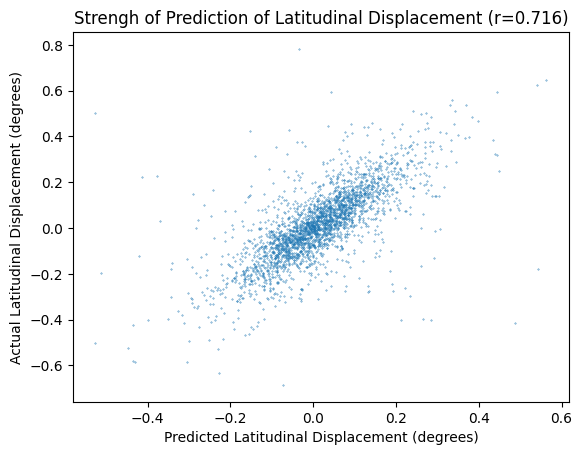

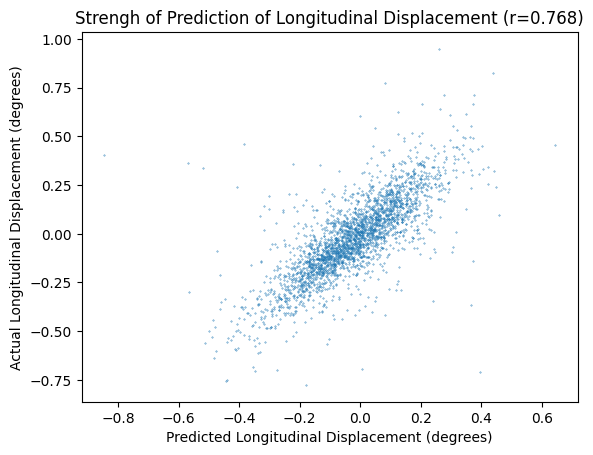

In [31]:
Y = final[['dy', 'dx']].to_numpy()
X = final.drop(columns=['dy', 'dx']).to_numpy()
X = torch.tensor(X).float()
Y = torch.tensor(Y).float()
X, Y = shuffle(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.11)


from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred_linear = model.predict(X_test)
r_squared = r2_score(Y_test, Y_pred_linear)
R = np.sqrt(r_squared)

def corr_coef(x, y):
    num = np.mean(x * y) - np.mean(x)*np.mean(y)
    denom = np.std(x) * np.std(y)
    return num / denom

print("Coefficient of Multiple Correlation (R):", R)
print('mean square error:', np.mean((Y_pred_linear - Y_test.detach().numpy())**2))

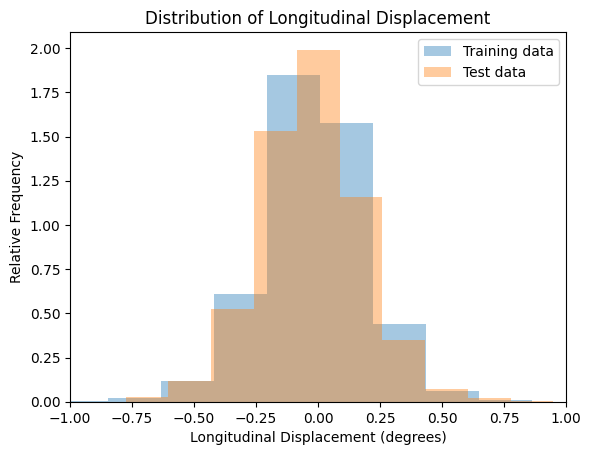

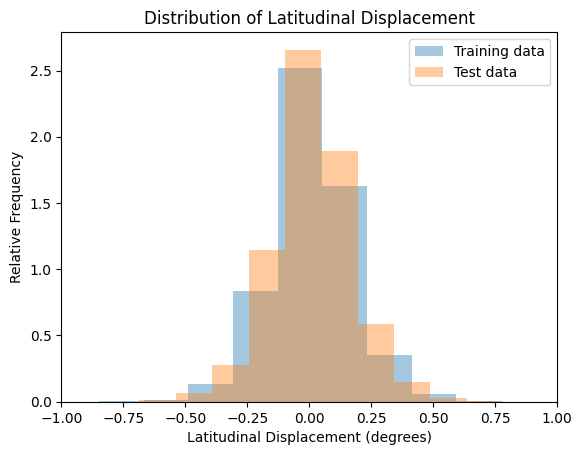

In [32]:
plt.hist(Y_train[:, 1], density=True, alpha=0.4)
plt.hist(Y_test[:, 1], density=True, alpha=0.4)
plt.title('Distribution of Longitudinal Displacement')
plt.xlabel('Longitudinal Displacement (degrees)')
plt.ylabel('Relative Frequency');
plt.legend(['Training data', 'Test data'])
plt.xlim([-1, 1])
plt.show()

plt.hist(Y_train[:, 0], density = True, alpha=0.4)
plt.hist(Y_test[:, 0], density = True, alpha=0.4)
plt.title('Distribution of Latitudinal Displacement')
plt.xlabel('Latitudinal Displacement (degrees)')
plt.ylabel('Relative Frequency');
plt.legend(['Training data', 'Test data'])
plt.xlim([-1, 1])
plt.show()

In [33]:
# play with regularization like dropout and batchnorm
# regularization -> lower patience

# look at distributions of train, test, validation before training

# more layers
model = nn.Sequential(
    nn.Linear(X.size()[1], 256),
    nn.LeakyReLU(),
    nn.Linear(256, 128),
    nn.Dropout(.5),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 32),
    nn.LeakyReLU(),
    nn.Linear(32, 16),
    nn.LeakyReLU(),
    nn.Linear(16, 8),
    nn.LeakyReLU(),
    nn.Linear(8, 2)
).to(device)
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

# define a custom loss
# guess standard deviation and mean
# there is a likelyhood for each value : new loss function
# 1 / likelyhood(observed)

batch_size = 32
early_stopping_patience = 15
best_val_loss = float('inf')
patience_counter = 0

training_losses = []
val_losses = []

# more epochs
for epoch in range(1000):
    model.train()
    
    for i in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        x_batch = X_train[i:i+batch_size].to(device)
        y_batch = Y_train[i:i+batch_size].to(device)
        guess = model(x_batch)
        loss = criterion(guess, y_batch)
        loss.backward()
        optimizer.step()
        
    training_losses.append(loss.cpu().detach().numpy())
    print("training loss:", training_losses[-1])
    
    model.eval()
    with torch.no_grad():
        val_losses.append(criterion(model(X_val.to(device)), Y_val.to(device)).cpu().detach().numpy())
    
    # havent improved in the last 15, quit
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            break

training loss: 0.018191172
training loss: 0.014222402
training loss: 0.013532885
training loss: 0.012369282
training loss: 0.012643579
training loss: 0.011158231
training loss: 0.01178492
training loss: 0.011755904
training loss: 0.009994278
training loss: 0.009236895
training loss: 0.01469854
training loss: 0.011741178
training loss: 0.011478173
training loss: 0.013478162
training loss: 0.009053714
training loss: 0.010888883
training loss: 0.009372394
training loss: 0.010458195
training loss: 0.011705274
training loss: 0.009711351
training loss: 0.011019486
training loss: 0.007938302
training loss: 0.0096954815
training loss: 0.0069770864
training loss: 0.010585903
training loss: 0.00755442
training loss: 0.0075663077
training loss: 0.011750582
training loss: 0.0058136913
training loss: 0.006174191
training loss: 0.006310995
training loss: 0.00674661
training loss: 0.008162803
training loss: 0.011744563
training loss: 0.008409185
training loss: 0.008778149
training loss: 0.00439786
tr

test loss: 0.01181597


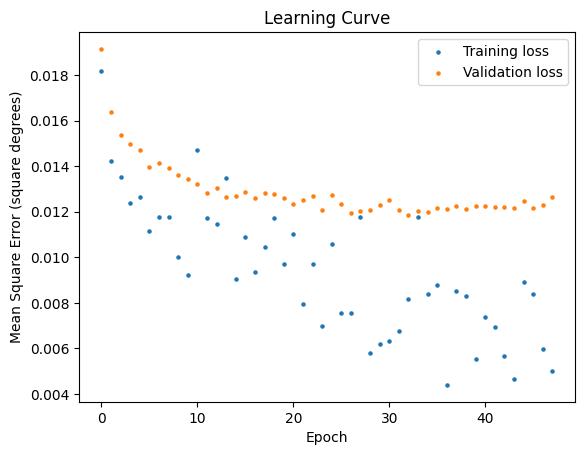

In [34]:
model.eval()
with torch.no_grad():
    print("test loss:", criterion(model(X_test.to(device)), Y_test.to(device)).cpu().detach().numpy())
    
plt.scatter(np.arange(len(training_losses)), training_losses, s=5)
plt.scatter(np.arange(len(val_losses)), val_losses, s=5)
plt.title('Learning Curve')
plt.xlabel('Epoch');
plt.ylabel('Mean Square Error (square degrees)')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

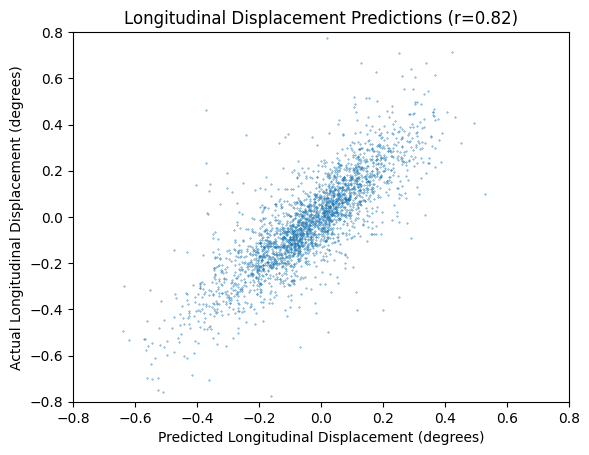

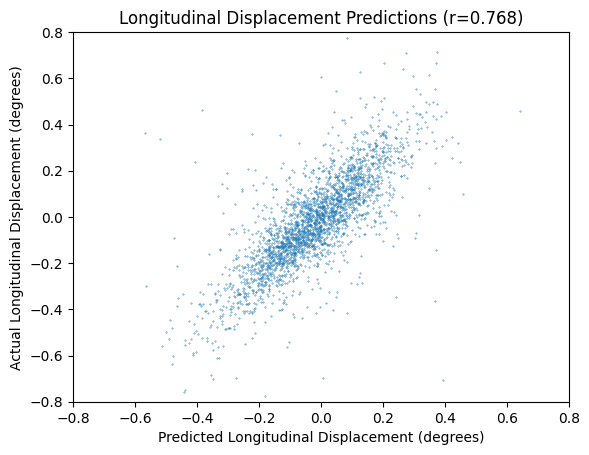

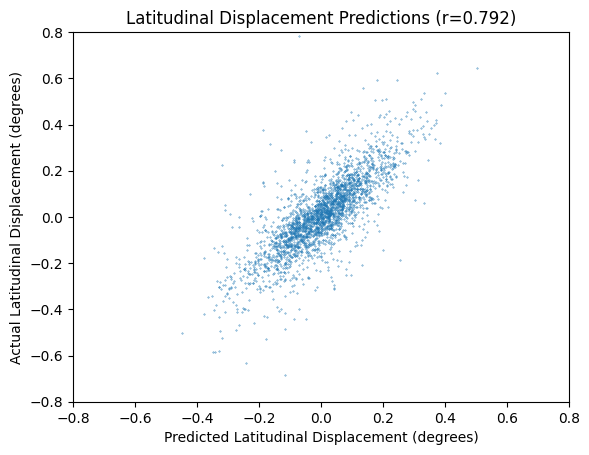

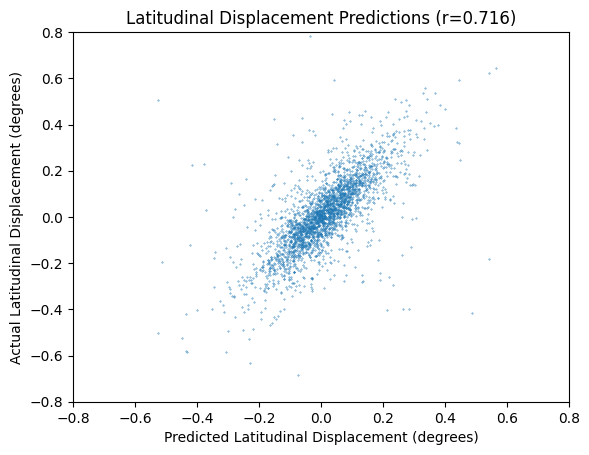

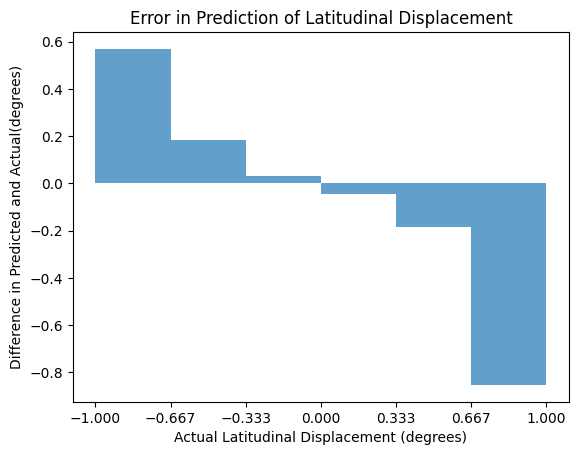

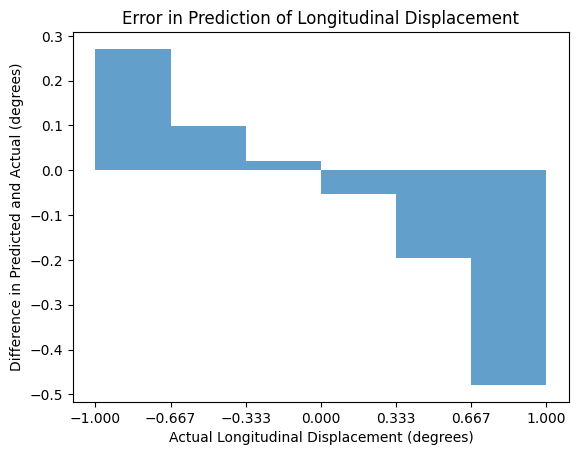

nn mean square error: 0.01181597
linear mean square error: 0.01491991
nn mad: 0.07630949
linear mad: 0.0828693


In [44]:
Y_pred = model(X_test.to(device)).cpu()

plt.scatter(Y_pred.detach().numpy()[:, 1], Y_test.detach().numpy()[:, 1], s=.1)
plt.title(f'Longitudinal Displacement Predictions (r={round(1e3*corr_coef(Y_pred.detach().numpy()[:, 1], Y_test.detach().numpy()[:, 1]))/1e3})')
plt.xlabel('Predicted Longitudinal Displacement (degrees)')
plt.ylabel('Actual Longitudinal Displacement (degrees)')
plt.xlim([-.8, .8])
plt.ylim([-.8, .8])
plt.show()

plt.scatter(Y_pred_linear[:, 1], Y_test.detach().numpy()[:, 1], s=.1)
plt.title(f'Longitudinal Displacement Predictions (r={round(1e3*corr_coef(Y_pred_linear[:, 1], Y_test.detach().numpy()[:, 1]))/1e3})')
plt.xlabel('Predicted Longitudinal Displacement (degrees)')
plt.ylabel('Actual Longitudinal Displacement (degrees)')
plt.xlim([-.8, .8])
plt.ylim([-.8, .8])
plt.show()

plt.scatter(Y_pred.detach().numpy()[:, 0], Y_test.detach().numpy()[:, 0], s=0.1)
plt.title(f'Latitudinal Displacement Predictions (r={round(1e3*corr_coef(Y_pred.detach().numpy()[:, 0], Y_test.detach().numpy()[:, 0]))/1e3})')
plt.xlabel('Predicted Latitudinal Displacement (degrees)')
plt.ylabel('Actual Latitudinal Displacement (degrees)')
plt.xlim([-.8, .8])
plt.ylim([-.8, .8])
plt.show()

plt.scatter(Y_pred_linear[:, 0], Y_test[:, 0], s=.1)
plt.title(f'Latitudinal Displacement Predictions (r={round(1e3*corr_coef(Y_pred_linear[:, 0], Y_test.detach().numpy()[:, 0]))/1e3})')
plt.xlabel('Predicted Latitudinal Displacement (degrees)')
plt.ylabel('Actual Latitudinal Displacement (degrees)')
plt.xlim([-.8, .8])
plt.ylim([-.8, .8])
plt.show()


num_bins = 6
bin_boundaries = np.linspace(-1, 1, num_bins + 1)
bin_boundaries
bins = np.digitize(Y_test.detach()[:, 0], bin_boundaries)
errors = (Y_pred.detach()[:, 0] - Y_test.detach()[:, 0]).numpy()
avg_errors = [np.mean(errors[bins == i]) for i in range(1, num_bins + 1)]
plt.bar(bin_boundaries[:-1], avg_errors, width=np.diff(bin_boundaries), align='edge', alpha=0.7)
plt.xlabel('Actual Latitudinal Displacement (degrees)')
plt.ylabel('Difference in Predicted and Actual(degrees)')
plt.title('Error in Prediction of Latitudinal Displacement')
plt.xticks(bin_boundaries)
plt.show()

bin_boundaries = np.linspace(-1, 1, num_bins + 1)
bin_boundaries
bins = np.digitize(Y_test.detach()[:, 1], bin_boundaries)
errors = (Y_pred.detach()[:, 1] - Y_test.detach()[:, 1]).numpy()
avg_errors = [np.mean(errors[bins == i]) for i in range(1, num_bins + 1)]
plt.bar(bin_boundaries[:-1], avg_errors, width=np.diff(bin_boundaries), align='edge', alpha=0.7)
plt.xlabel('Actual Longitudinal Displacement (degrees)')
plt.ylabel('Difference in Predicted and Actual (degrees)')
plt.title('Error in Prediction of Longitudinal Displacement')
plt.xticks(bin_boundaries)
plt.show()

print('nn mean square error:', np.mean((Y_pred.detach().numpy() - Y_test.detach().numpy())**2))
print('linear mean square error:', np.mean((Y_pred_linear - Y_test.detach().numpy())**2))

print('nn mad:', np.mean(np.abs(Y_pred.detach().numpy() - Y_test.detach().numpy())))
print('linear mad:', np.mean(np.abs(Y_pred_linear - Y_test.detach().numpy())))

In [45]:
# picking a contiguous sequence
just_one = data[data.get('float') == 2902573.0].head(14)

small_test = torch.tensor(just_one[chosen_params[:-2]].to_numpy()).float().to(device)
pred = model(small_test).detach().cpu().numpy()
# pred = model.predict(small_test)
just_one = just_one.assign(pnlat = pred[:, 0] + just_one.get('lat'))
just_one = just_one.assign(pnlon = pred[:, 1] + just_one.get('lon')).reset_index()
just_one.to_csv('just_one.csv')
just_one

,index,Unnamed: 0,folderidx,float,profileidx,year,month,day,lat,lon,...,prev3_ts7,prev3_ts8,prev3_dy,prev3_dx,ssh1,ssh2,bath1,bath2,pnlat,pnlon
0,0,112,2.0,2902573.0,125.0,2017.0,3.0,3.0,-27.995,-120.065,...,-0.483323,0.657106,-0.229,-0.273,0.630030,-1.000000,1.000000,0.031732,-28.130300,-120.270672
1,1,113,2.0,2902573.0,126.0,2017.0,3.0,13.0,-28.145,-120.164,...,-0.505345,0.637936,-0.136,-0.286,1.000000,-0.779453,1.000000,0.200338,-28.283860,-120.247184
2,2,114,2.0,2902573.0,127.0,2017.0,3.0,23.0,-28.267,-120.216,...,-0.442858,0.514106,-0.128,-0.221,0.905253,-1.000000,1.000000,0.119882,-28.370750,-120.307094
3,3,115,2.0,2902573.0,128.0,2017.0,4.0,3.0,-28.250,-120.344,...,-0.452919,0.496550,-0.150,-0.099,1.000000,0.031837,1.000000,0.073253,-28.258578,-120.504301
4,4,116,2.0,2902573.0,129.0,2017.0,4.0,13.0,-28.163,-120.430,...,-0.636107,0.681706,-0.122,-0.052,-0.189491,-1.000000,1.000000,0.232778,-28.073767,-120.559083
5,5,117,2.0,2902573.0,130.0,2017.0,4.0,22.0,-27.990,-120.652,...,-0.601384,0.508919,0.017,-0.128,-0.053026,-1.000000,-0.068842,1.000000,-27.875621,-120.892297
6,6,118,2.0,2902573.0,131.0,2017.0,5.0,2.0,-27.808,-120.970,...,-0.737335,0.710894,0.087,-0.086,-0.471371,-1.000000,0.450265,1.000000,-27.702930,-121.282745
7,7,119,2.0,2902573.0,132.0,2017.0,5.0,12.0,-27.651,-121.421,...,-0.644372,0.550055,0.173,-0.222,-0.104666,-1.000000,-0.340642,1.000000,-27.578809,-121.808021
8,8,120,2.0,2902573.0,133.0,2017.0,5.0,22.0,-27.609,-121.743,...,-0.607703,0.579257,0.182,-0.318,-0.082962,-1.000000,1.000000,0.299927,-27.614196,-122.014651
9,9,121,2.0,2902573.0,134.0,2017.0,6.0,2.0,-27.623,-122.033,...,-0.630542,0.705496,0.157,-0.451,0.088565,-1.000000,0.717516,1.000000,-27.669814,-122.269726


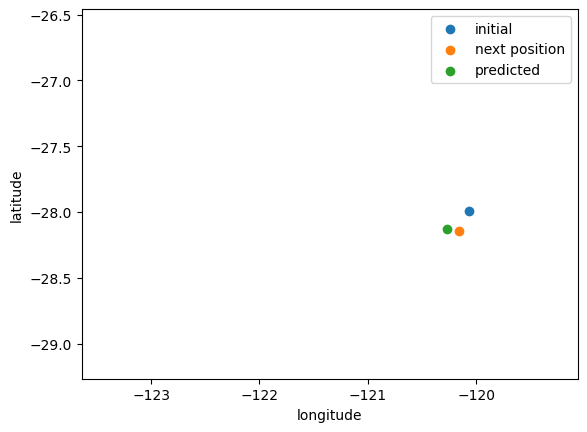

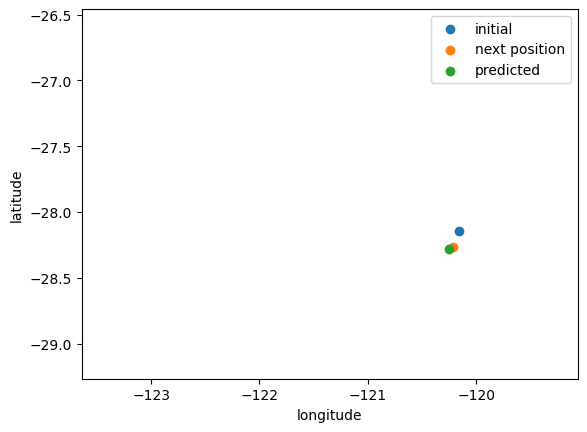

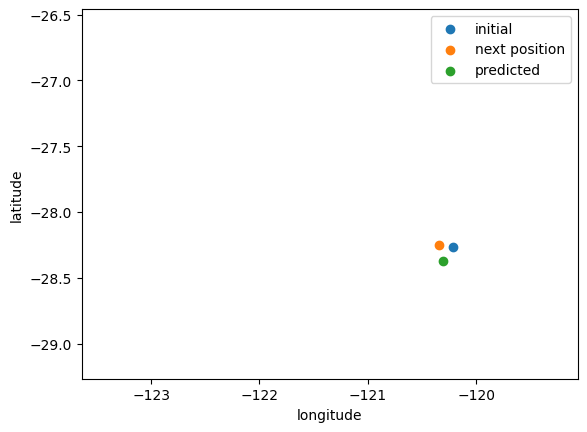

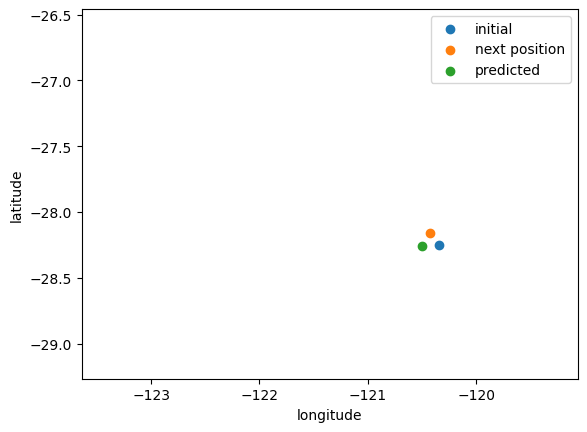

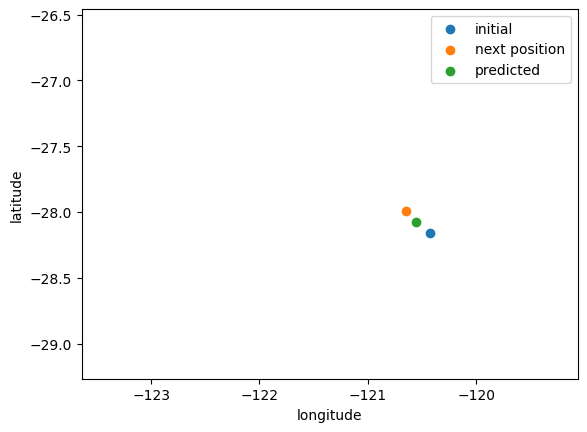

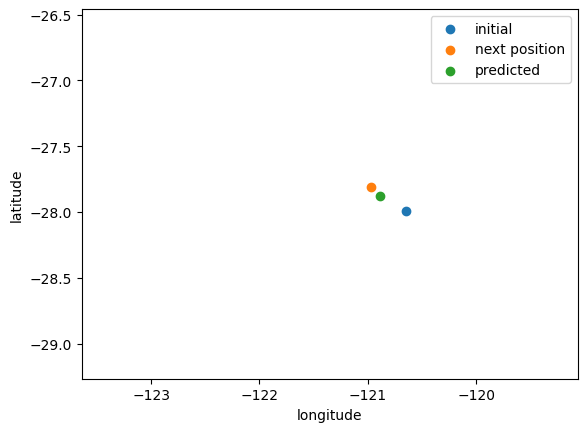

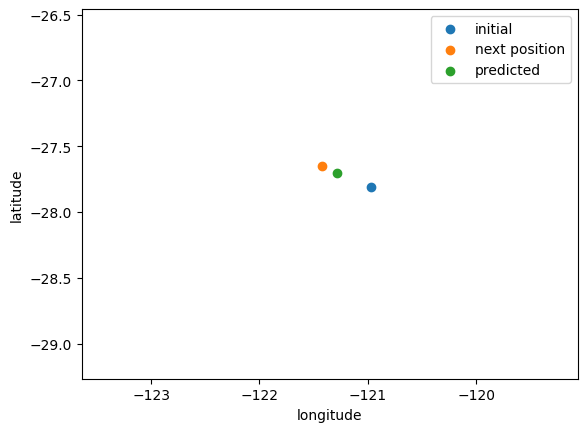

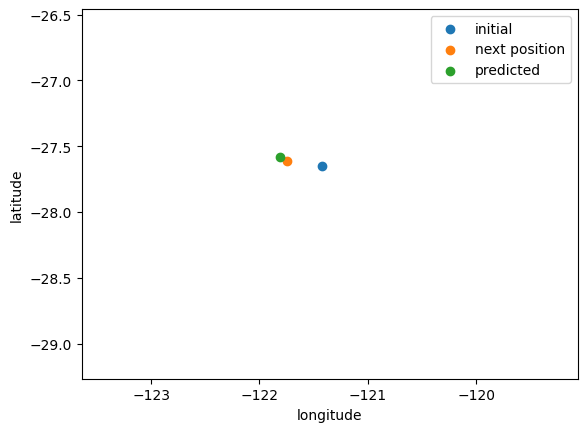

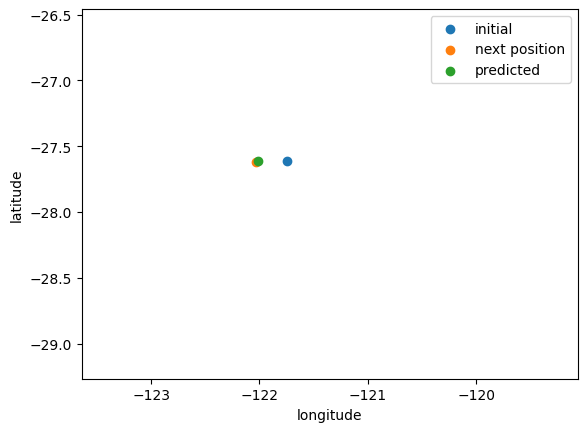

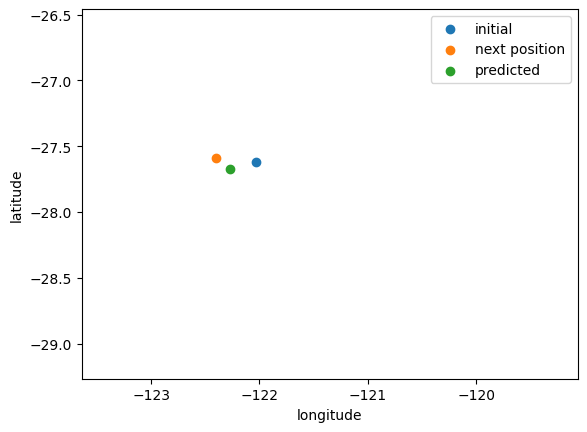

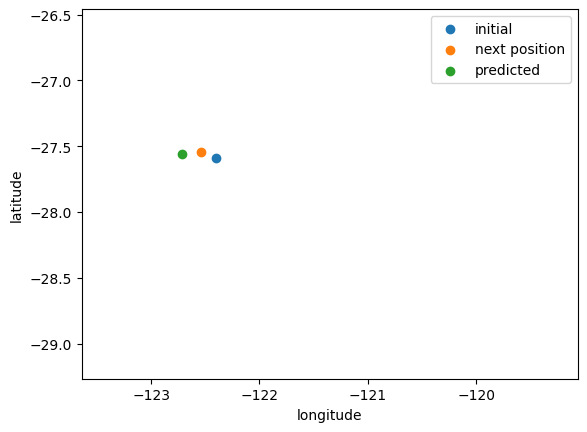

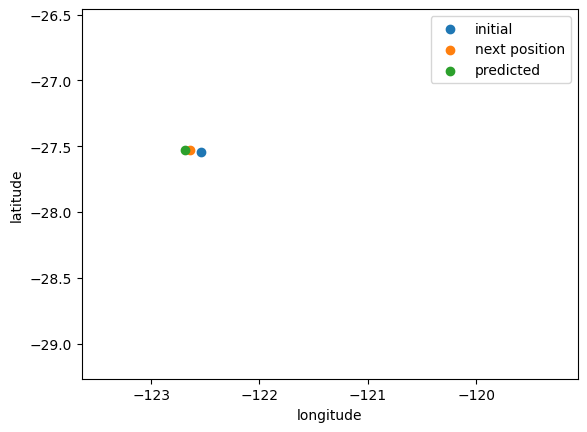

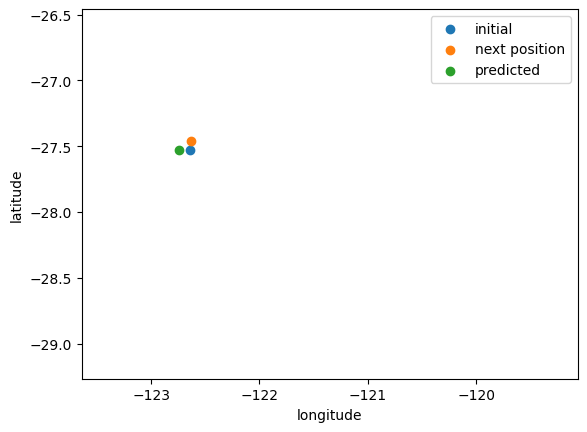

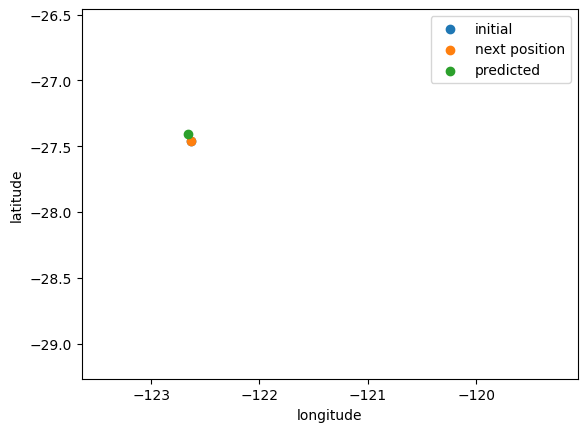

In [46]:
for i in range(just_one.shape[0]):
  y_plot = [just_one.get('lat')[i], just_one.get('nlat')[i], just_one.get('pnlat')[i]]
  x_plot = [just_one.get('lon')[i], just_one.get('nlon')[i], just_one.get('pnlon')[i]]
  for j in range(3):
    plt.scatter(x_plot[j], y_plot[j])
  plt.legend(['initial', 'next position', 'predicted'])
  plt.xlim((just_one.get('lon').min()-1, just_one.get('lon').max()+1))
  plt.ylim((just_one.get('lat').min()-1, just_one.get('lat').max()+1))
  plt.xlabel('longitude')
  plt.ylabel('latitude')
  plt.show()